# ***Custom Neck Using Pre-trained backbone and head custom neck***</center>


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image
import cv2
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
import zipfile

import warnings
warnings.filterwarnings('ignore')


In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
set_seed(seed)

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch Version: 2.9.0+cu126
CUDA Available: True
CUDA Device: Tesla T4
Using device: cuda


**1) Download + Extract GTSDB from Kaggle**

In [ ]:
import os
import zipfile
from google.colab import files

# Kaggle setup
!mkdir -p ~/.kaggle

print("Upload kaggle.json:")
uploaded = files.upload()

!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
print("Downloading GTSDB dataset...")
!kaggle datasets download -d safabouguezzi/german-traffic-sign-detection-benchmark-gtsdb

# Extract dataset
print("Extracting...")
with zipfile.ZipFile('german-traffic-sign-detection-benchmark-gtsdb.zip', 'r') as f:
    f.extractall('gtsdb_data')

print("Dataset ready!")


**2) Define Dataset Paths**

In [ ]:
DATASET_ROOT = "gtsdb_data"

TRAIN_DIR = os.path.join(DATASET_ROOT, "TrainIJCNN2013", "TrainIJCNN2013")
TEST_DIR  = os.path.join(DATASET_ROOT, "TestIJCNN2013", "TestIJCNN2013Download")

print("TRAIN_DIR:", TRAIN_DIR)
print("TEST_DIR:", TEST_DIR)


TRAIN_DIR: gtsdb_data/TrainIJCNN2013/TrainIJCNN2013
TEST_DIR: gtsdb_data/TestIJCNN2013/TestIJCNN2013Download


**3) Inspect Directories**

In [ ]:
print("\nChecking dataset structure...\n")

if os.path.exists(TRAIN_DIR):
    train_files = sorted([f for f in os.listdir(TRAIN_DIR) if f.endswith(".ppm")])
    print(f"Train images: {len(train_files)}")
    print("First 5 train images:", train_files[:5])
else:
    print(" TRAIN directory not found!")

if os.path.exists(TEST_DIR):
    test_files = sorted([f for f in os.listdir(TEST_DIR) if f.endswith(".ppm")])
    print(f"Test images: {len(test_files)}")
    print("First 5 test images:", test_files[:5])
else:
    print(" TEST directory not found!")



Checking dataset structure...

Train images: 600
First 5 train images: ['00000.ppm', '00001.ppm', '00002.ppm', '00003.ppm', '00004.ppm']
Test images: 300
First 5 test images: ['00000.ppm', '00001.ppm', '00002.ppm', '00003.ppm', '00004.ppm']


**4) Dataset Class (CLEAN)**

In [ ]:
class GTSDBDataset(Dataset):
    def __init__(self, root_dir, transforms=None, indices=None):

        self.root_dir = root_dir
        self.transforms = transforms


        annotations = {}
        gt_file = os.path.join(root_dir, "gt.txt")
        if not os.path.exists(gt_file):
            raise FileNotFoundError("gt.txt not found in: " + root_dir)

        with open(gt_file, "r") as f:
            for line in f:
                parts = line.strip().split(";")
                img_name = parts[0]
                x1, y1, x2, y2 = map(int, parts[1:5])
                cls = int(parts[5]) + 1

                if img_name not in annotations:
                    annotations[img_name] = {"boxes": [], "labels": []}

                annotations[img_name]["boxes"].append([x1, y1, x2, y2])
                annotations[img_name]["labels"].append(cls)


        self.images = []
        self.targets = []
        for img_name, ann in sorted(annotations.items()):
            img_path = os.path.join(root_dir, img_name)
            if not os.path.exists(img_path):
                continue

            self.images.append(img_path)
            boxes = torch.tensor(ann["boxes"], dtype=torch.float32)
            labels = torch.tensor(ann["labels"], dtype=torch.int64)
            area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
            iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
            self.targets.append({
                "boxes": boxes,
                "labels": labels,
                "area": area,
                "iscrowd": iscrowd,
            })


        if indices is not None:
            self.images = [self.images[i] for i in indices]
            self.targets = [self.targets[i] for i in indices]

        print(f" Loaded {len(self.images)} images with bounding boxes. (transforms={'yes' if transforms else 'no'})")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        target = self.targets[idx].copy()

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        boxes = target["boxes"].numpy().astype(float).tolist()
        labels = target["labels"].numpy().tolist()


        if self.transforms:
            augmented = self.transforms(image=img, bboxes=boxes, labels=labels)
            img = augmented['image']
            boxes = augmented['bboxes']
            labels = augmented['labels']


        if isinstance(img, torch.Tensor):
            img = img.float()
        else:
            img = torch.from_numpy(img)
            img = img.permute(2,0,1).float()

        img = img / 255.0


        boxes_t = torch.tensor(boxes, dtype=torch.float32) if len(boxes)>0 else torch.zeros((0,4))
        labels_t = torch.tensor(labels, dtype=torch.int64) if len(labels)>0 else torch.zeros((0,), dtype=torch.int64)

        target = {
            "boxes": boxes_t,
            "labels": labels_t,
            "area": (boxes_t[:,2]-boxes_t[:,0])*(boxes_t[:,3]-boxes_t[:,1]) if boxes_t.numel() else torch.zeros((0,)),
            "iscrowd": torch.zeros((len(labels_t),), dtype=torch.int64),
            "image_id": torch.tensor([idx])
        }

        return img, target



**5) Create Dataset + DataLoader**

In [ ]:
dataset = GTSDBDataset("./gtsdb_data/TrainIJCNN2013/TrainIJCNN2013")
print("Total images:", len(dataset))


 Loaded 506 images with bounding boxes. (transforms=no)
Total images: 506


In [ ]:
dataset = GTSDBDataset(root_dir=TRAIN_DIR)

print(f"Total samples in dataset: {len(dataset)}")

 Loaded 506 images with bounding boxes. (transforms=no)
Total samples in dataset: 506


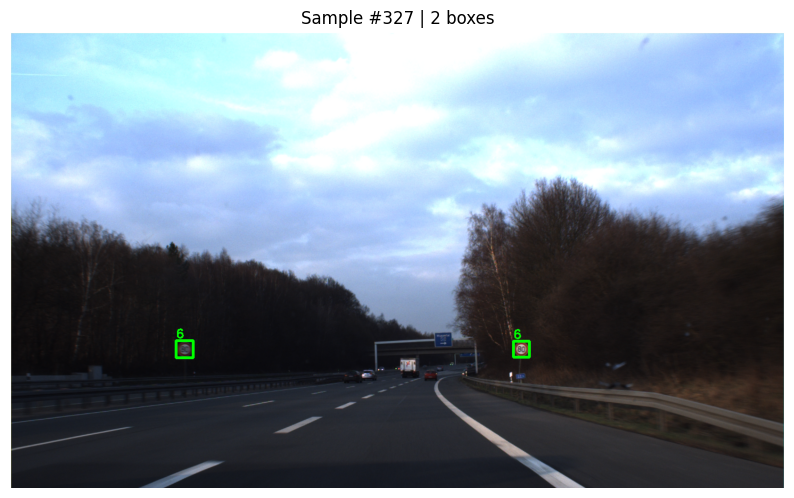

In [ ]:
import random
import matplotlib.pyplot as plt
import cv2

def visualize_random_sample(dataset):
    idx = random.randint(0, len(dataset) - 1)

    img, target = dataset[idx]

    img_np = img.permute(1, 2, 0).numpy().copy()
    img_np = (img_np * 255).astype("uint8")

    boxes = target["boxes"].numpy()
    labels = target["labels"].numpy()

    img_draw = img_np.copy()

    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img_draw, (x1, y1), (x2, y2), (0,255,0), 3)
        cv2.putText(img_draw, str(label), (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

    plt.figure(figsize=(10, 7))
    plt.imshow(img_draw)
    plt.title(f"Sample #{idx} | {len(boxes)} boxes")
    plt.axis("off")
    plt.show()


visualize_random_sample(dataset)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


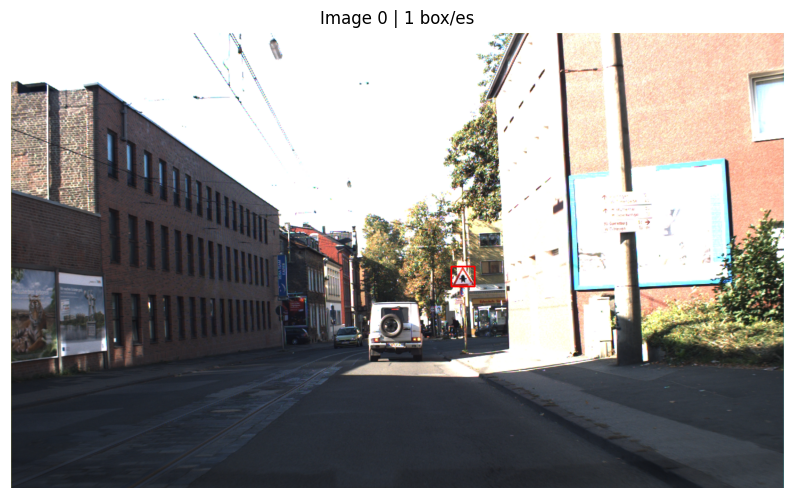

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


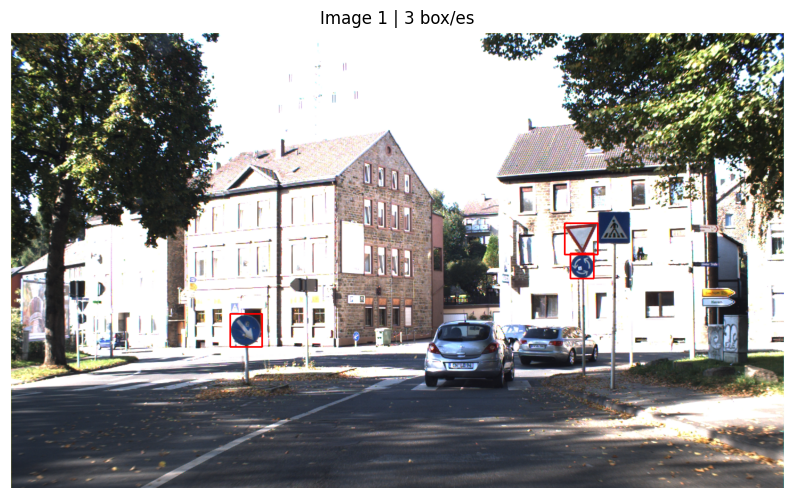

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


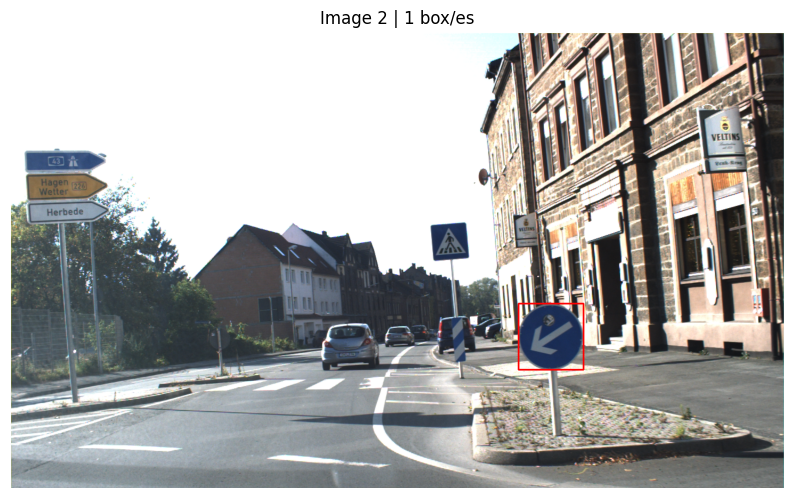

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


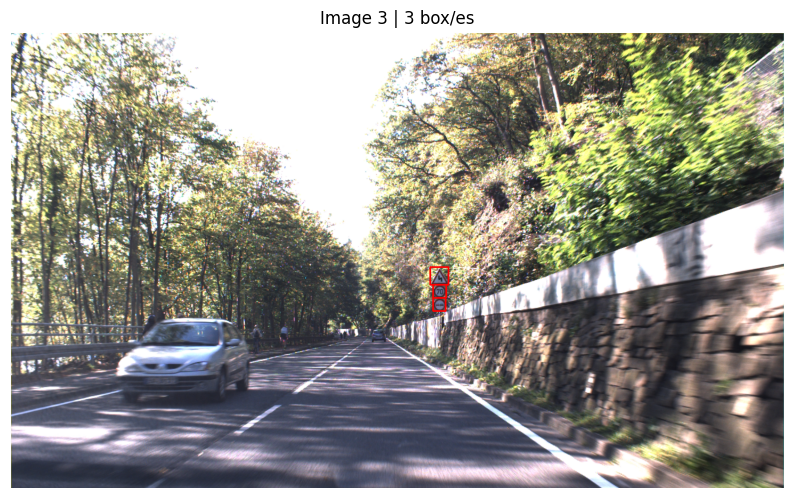

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


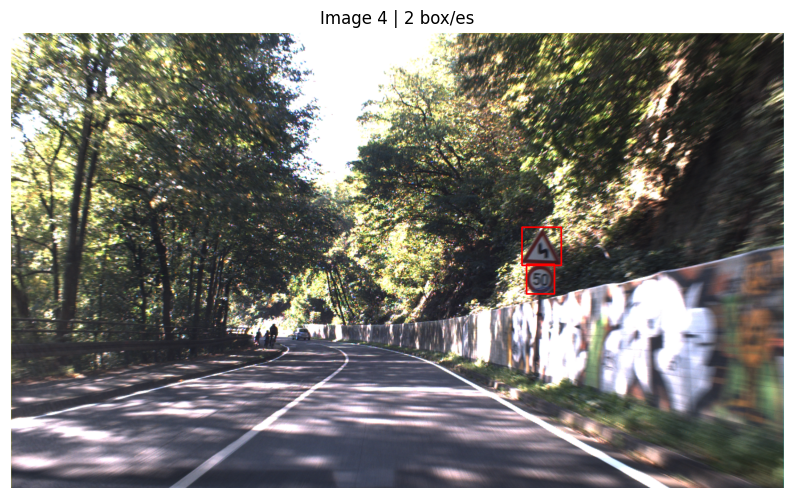

In [ ]:
def visualize_first_n(dataset, n=5):
    for i in range(n):
        img, target = dataset[i]
        img_np = img.permute(1,2,0).numpy()
        boxes = target["boxes"].numpy()

        img_draw = img_np.copy()
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img_draw, (x1, y1), (x2, y2), (255,0,0), 2)

        plt.figure(figsize=(10,7))
        plt.imshow(img_draw)
        plt.title(f"Image {i} | {len(boxes)} box/es")
        plt.axis("off")
        plt.show()

visualize_first_n(dataset, n=5)


**6) Augmentation**

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import torch
import cv2


train_aug = A.Compose([
    A.Rotate(limit=8, p=0.3),
    A.RandomBrightnessContrast(p=0.3),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))



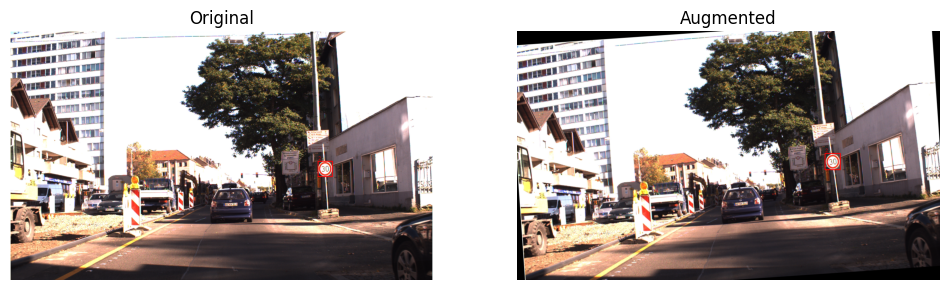

In [ ]:
import matplotlib.pyplot as plt
import random
import cv2

def draw_boxes_on_np(img_np, boxes, labels, color=(255,0,0)):
    out = img_np.copy()
    for (x1,y1,x2,y2), lbl in zip(boxes, labels):
        cv2.rectangle(out, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
        cv2.putText(out, str(int(lbl)), (int(x1), int(max(0,y1-5))), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return out


idx = random.randint(0, len(dataset)-1)
img_path = dataset.images[idx]
orig = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
boxes = dataset.targets[idx]['boxes'].numpy()
labels = dataset.targets[idx]['labels'].numpy()

aug = train_aug(image=orig, bboxes=boxes.tolist(), labels=labels.tolist())
img_aug = aug['image']; boxes_aug = aug['bboxes']; labels_aug = aug['labels']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(draw_boxes_on_np(orig, boxes, labels))
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Augmented')
plt.imshow(draw_boxes_on_np(img_aug, boxes_aug, labels_aug))
plt.axis('off')

plt.show()



**Create a reproducible train/val split and datasets with different transforms**

In [ ]:
full_dataset = GTSDBDataset(root_dir=TRAIN_DIR, transforms=None)

num_samples = len(full_dataset)
all_indices = list(range(num_samples))


from sklearn.model_selection import train_test_split
train_idx, val_idx = train_test_split(all_indices, test_size=0.2, random_state=seed, shuffle=True)

print(f"Total samples: {num_samples} | Train: {len(train_idx)} | Val: {len(val_idx)}")


train_dataset = GTSDBDataset(root_dir=TRAIN_DIR, transforms=train_aug, indices=train_idx)
val_dataset   = GTSDBDataset(root_dir=TRAIN_DIR, transforms=None,      indices=val_idx)


def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=4, shuffle=False, collate_fn=collate_fn)


 Loaded 506 images with bounding boxes. (transforms=no)
Total samples: 506 | Train: 404 | Val: 102
 Loaded 404 images with bounding boxes. (transforms=yes)
 Loaded 102 images with bounding boxes. (transforms=no)


**Quick visual check to confirm augmentation is applied only to train_dataset**

Random train sample:
Random val sample:


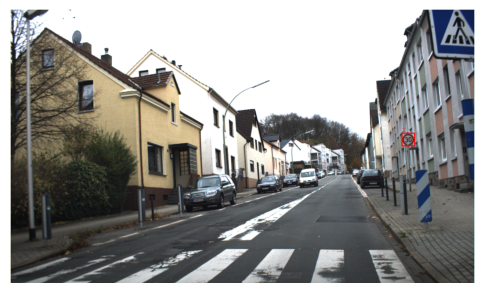

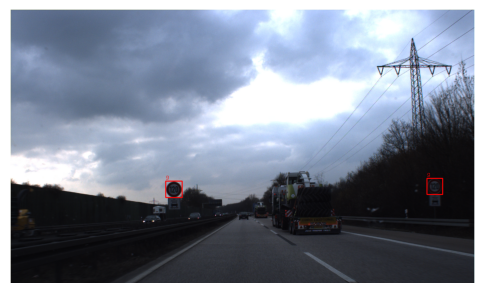

In [ ]:

def show_sample_from_dataset(ds, idx):
    img, target = ds[idx]
    img_np = img.permute(1,2,0).numpy()
    boxes = target["boxes"].numpy()
    labels = target["labels"].numpy()
    plt.figure(figsize=(6,4))
    plt.imshow(draw_boxes_on_np((img_np*255).astype('uint8'), boxes, labels))
    plt.axis('off')

print("Random train sample:")
show_sample_from_dataset(train_dataset, random.randint(0, len(train_dataset)-1))

print("Random val sample:")
show_sample_from_dataset(val_dataset, random.randint(0, len(val_dataset)-1))


**7) Build Faster R-CNN Model (CLEAN)**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone


class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.mlp = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // ratio, in_channels, 1, bias=False)
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.mlp(self.avg_pool(x))
        max_out = self.mlp(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)


class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        max_v, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg, max_v], dim=1)
        return self.sigmoid(self.conv(concat))



class StrongNeck(nn.Module):
    def __init__(self, in_channels=256):
        super().__init__()

        self.branch1 = nn.Conv2d(in_channels, 256, 3, padding=1, dilation=1)
        self.branch2 = nn.Conv2d(in_channels, 256, 3, padding=2, dilation=2)
        self.branch3 = nn.Conv2d(in_channels, 256, 3, padding=3, dilation=3)

        self.dw = nn.Conv2d(256, 256, 3, padding=1, groups=256)
        self.pw = nn.Conv2d(256, 256, 1)


        self.ca = ChannelAttention(256)
        self.sa = SpatialAttention()
        self.fuse = nn.Conv2d(256 * 3, 256, 1)

    def forward(self, x):
        b1 = F.relu(self.branch1(x))
        b2 = F.relu(self.branch2(x))
        b3 = F.relu(self.branch3(x))

        merged = torch.cat([b1, b2, b3], dim=1)
        merged = self.fuse(merged)

        bottleneck = self.dw(merged)
        bottleneck = F.relu(self.pw(bottleneck))

        att = self.ca(bottleneck) * bottleneck
        att = self.sa(att) * att

        return att + x




class CustomStrongFPN(nn.Module):
    def __init__(self, base_fpn):
        super().__init__()
        self.fpn = base_fpn
        self.out_channels = 256

        self.necks = nn.ModuleDict({
            key: StrongNeck(256)
            for key in ["0", "1", "2", "3", "pool"]
        })

    def forward(self, x):
        features = self.fpn(x)
        out = {}

        for k, v in features.items():
            if k in self.necks:
                out[k] = self.necks[k](v)
            else:
                out[k] = v
        return out



from torchvision.models.detection import FasterRCNN
def get_custom_neck_model(num_classes=44):
    base_fpn = resnet_fpn_backbone(
        "resnet50",
        weights="IMAGENET1K_V2",
        trainable_layers=3
    )

    backbone = CustomStrongFPN(base_fpn)

    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        min_size=600,
        max_size=1000
    )
    return model


**7) Training Loop (Clean & Safe)**

In [ ]:
import torch
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
import time
import os
import json


model = get_custom_neck_model(num_classes=44).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()
num_epochs = 25

train_losses_epoch = []
val_losses_epoch = []

save_dir = "./training_runs/local"
os.makedirs(save_dir, exist_ok=True)
best_val_loss = float("inf")

print(" Starting Training...\n")

for epoch in range(num_epochs):

    model.train()
    total_train_loss = 0.0
    start = time.time()

    for batch_idx, (images, targets) in enumerate(train_loader):


        images = [img.to(device).float() for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


        with torch.cuda.amp.autocast(enabled=False):
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()

        if batch_idx % 10 == 0:
            print(
                f"Epoch {epoch+1}/{num_epochs} | Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}"
            )

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses_epoch.append(avg_train_loss)
    print(
        f"\n Epoch {epoch+1} finished | Avg Training Loss: {avg_train_loss:.4f} | Time: {time.time() - start:.2f}s"
    )


    model.train()
    total_val_loss = 0.0

    with torch.no_grad():
        for images, targets in val_loader:

            images = [img.to(device).float() for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.cuda.amp.autocast(enabled=False):
                loss_dict = model(images, targets)
                loss = sum(loss for loss in loss_dict.values())
                total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses_epoch.append(avg_val_loss)
    print(f" Validation Loss: {avg_val_loss:.4f}\n")

    epoch_path = os.path.join(save_dir, f"epoch_{epoch+1:03d}.pth")
    torch.save(model.state_dict(), epoch_path)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = os.path.join(save_dir, "best_model.pth")
        torch.save(model.state_dict(), best_model_path)
        print(f" Best Model Updated! Saved to {best_model_path}")

history = {
    "train_losses_epoch": train_losses_epoch,
    "val_losses_epoch": val_losses_epoch
}
history_path = os.path.join(save_dir, "history.json")
with open(history_path, "w") as f:
    json.dump(history, f)

print("\n Training Completed! History Saved = ", history_path)


 Starting Training...

Epoch 1/25 | Batch 0/101 | Loss: 4.7731
Epoch 1/25 | Batch 10/101 | Loss: 0.3187
Epoch 1/25 | Batch 20/101 | Loss: 0.3994
Epoch 1/25 | Batch 30/101 | Loss: 0.4062
Epoch 1/25 | Batch 40/101 | Loss: 0.2893
Epoch 1/25 | Batch 50/101 | Loss: 0.2471
Epoch 1/25 | Batch 60/101 | Loss: 0.4496
Epoch 1/25 | Batch 70/101 | Loss: 0.3355
Epoch 1/25 | Batch 80/101 | Loss: 0.2023
Epoch 1/25 | Batch 90/101 | Loss: 0.4492
Epoch 1/25 | Batch 100/101 | Loss: 0.2114

 Epoch 1 finished | Avg Training Loss: 0.4208 | Time: 86.91s
 Validation Loss: 0.2823

 Best Model Updated! Saved to ./training_runs/local/best_model.pth
Epoch 2/25 | Batch 0/101 | Loss: 0.2196
Epoch 2/25 | Batch 10/101 | Loss: 0.2105
Epoch 2/25 | Batch 20/101 | Loss: 0.4323
Epoch 2/25 | Batch 30/101 | Loss: 0.1316
Epoch 2/25 | Batch 40/101 | Loss: 0.3298
Epoch 2/25 | Batch 50/101 | Loss: 0.1500
Epoch 2/25 | Batch 60/101 | Loss: 0.1993
Epoch 2/25 | Batch 70/101 | Loss: 0.2459
Epoch 2/25 | Batch 80/101 | Loss: 0.1403
Epo

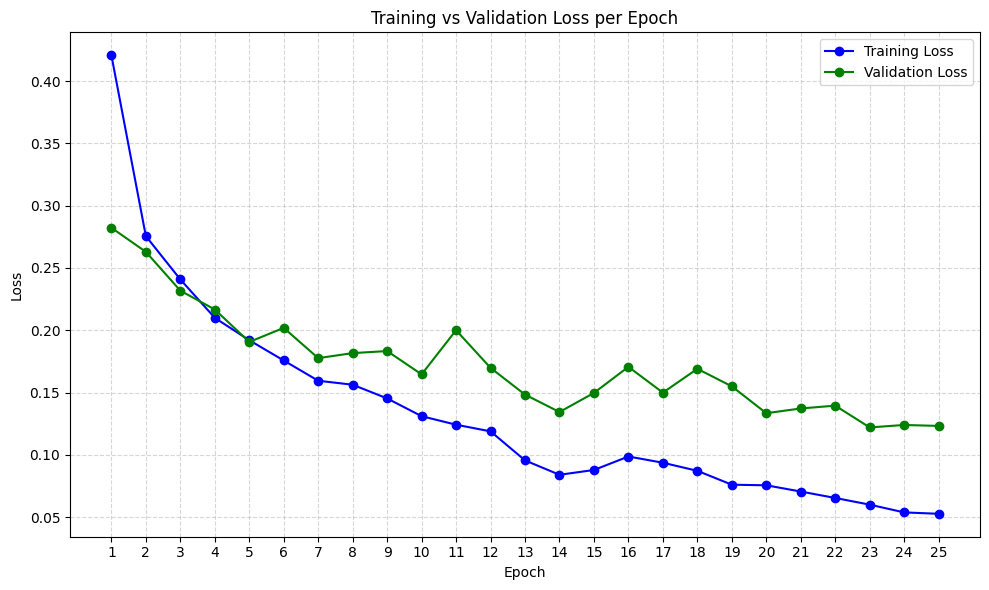

 Loss curve saved to: ./training_runs/local/loss_curve.png


In [ ]:
import json
import matplotlib.pyplot as plt
import os


save_dir = "./training_runs/local"
history_path = os.path.join(save_dir, "history.json")

with open(history_path, "r") as f:
    history = json.load(f)

train_losses = history["train_losses_epoch"]
val_losses = history["val_losses_epoch"]
epochs = range(1, len(train_losses) + 1)


plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, "o-", color="blue", label="Training Loss")
plt.plot(epochs, val_losses, "o-", color="green", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss per Epoch")
plt.xticks(epochs)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()


plot_path = os.path.join(save_dir, "loss_curve.png")
plt.savefig(plot_path, dpi=150)
plt.show()

print(f" Loss curve saved to: {plot_path}")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Load Best Model From Google Drive**

In [21]:
best_model_path = "/content/drive/MyDrive/GTSDB/Custom_Neck.pth"

model = get_custom_neck_model(num_classes=44)
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

print("Model loaded Successfully!")


Model loaded Successfully!


**Model Evalution Metrics For Annotated Test Images**

In [23]:
import os
import cv2
import torch
import matplotlib.pyplot as plt
from torchvision.ops import box_iou

test_folder = "/content/drive/MyDrive/GTSDB/labled_test"
anno_path = "/content/drive/MyDrive/GTSDB/anno.txt"


test_annotations = {}
with open(anno_path, "r") as f:
    for line in f:
        img, x1, y1, x2, y2, cls = line.strip().split(";")
        box = [float(x1), float(y1), float(x2), float(y2)]
        cls = int(cls)

        if img not in test_annotations:
            test_annotations[img] = {"boxes": [], "labels": []}

        test_annotations[img]["boxes"].append(box)
        test_annotations[img]["labels"].append(cls)



def evaluate_on_test(model, test_annotations, score_thresh=0.5, iou_thresh=0.5):
    precisions, recalls, f1s, aps = [], [], [], []

    for img_name, ann in test_annotations.items():
        img_path = os.path.join(test_folder, img_name)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_tensor = torch.tensor(img_rgb).permute(2,0,1).float() / 255.
        img_tensor = img_tensor.unsqueeze(0).to(device)

        gt_boxes = torch.tensor(ann["boxes"]).to(device)
        gt_labels = torch.tensor(ann["labels"]).to(device)

        with torch.no_grad():
            out = model(img_tensor)[0]

        mask = out["scores"] > score_thresh
        pred_boxes = out["boxes"][mask]
        pred_labels = out["labels"][mask]

        if len(pred_boxes) == 0:
            precisions.append(0); recalls.append(0); f1s.append(0); aps.append(0)
            continue

        ious = box_iou(pred_boxes, gt_boxes)
        matches = (ious > iou_thresh).sum(dim=1)

        TP = (matches > 0).sum().item()
        FP = len(pred_boxes) - TP
        FN = len(gt_boxes) - TP

        precision = TP / (TP + FP + 1e-6)
        recall = TP / (TP + FN + 1e-6)
        f1 = 2 * precision * recall / (precision + recall + 1e-6)

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        aps.append(precision)

    return {
        "Precision": sum(precisions)/len(precisions),
        "Recall": sum(recalls)/len(recalls),
        "F1-score": sum(f1s)/len(f1s),
        "mAP": sum(aps)/len(aps),
    }

metrics = evaluate_on_test(model, test_annotations)
print("Evaluation Metrics on Validation Set:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")






Evaluation Metrics on Validation Set:
Precision: 0.9000
Recall: 0.9000
F1-score: 0.8667
mAP: 0.9000


**Visualization of Orignal Images vs Predicted Images**

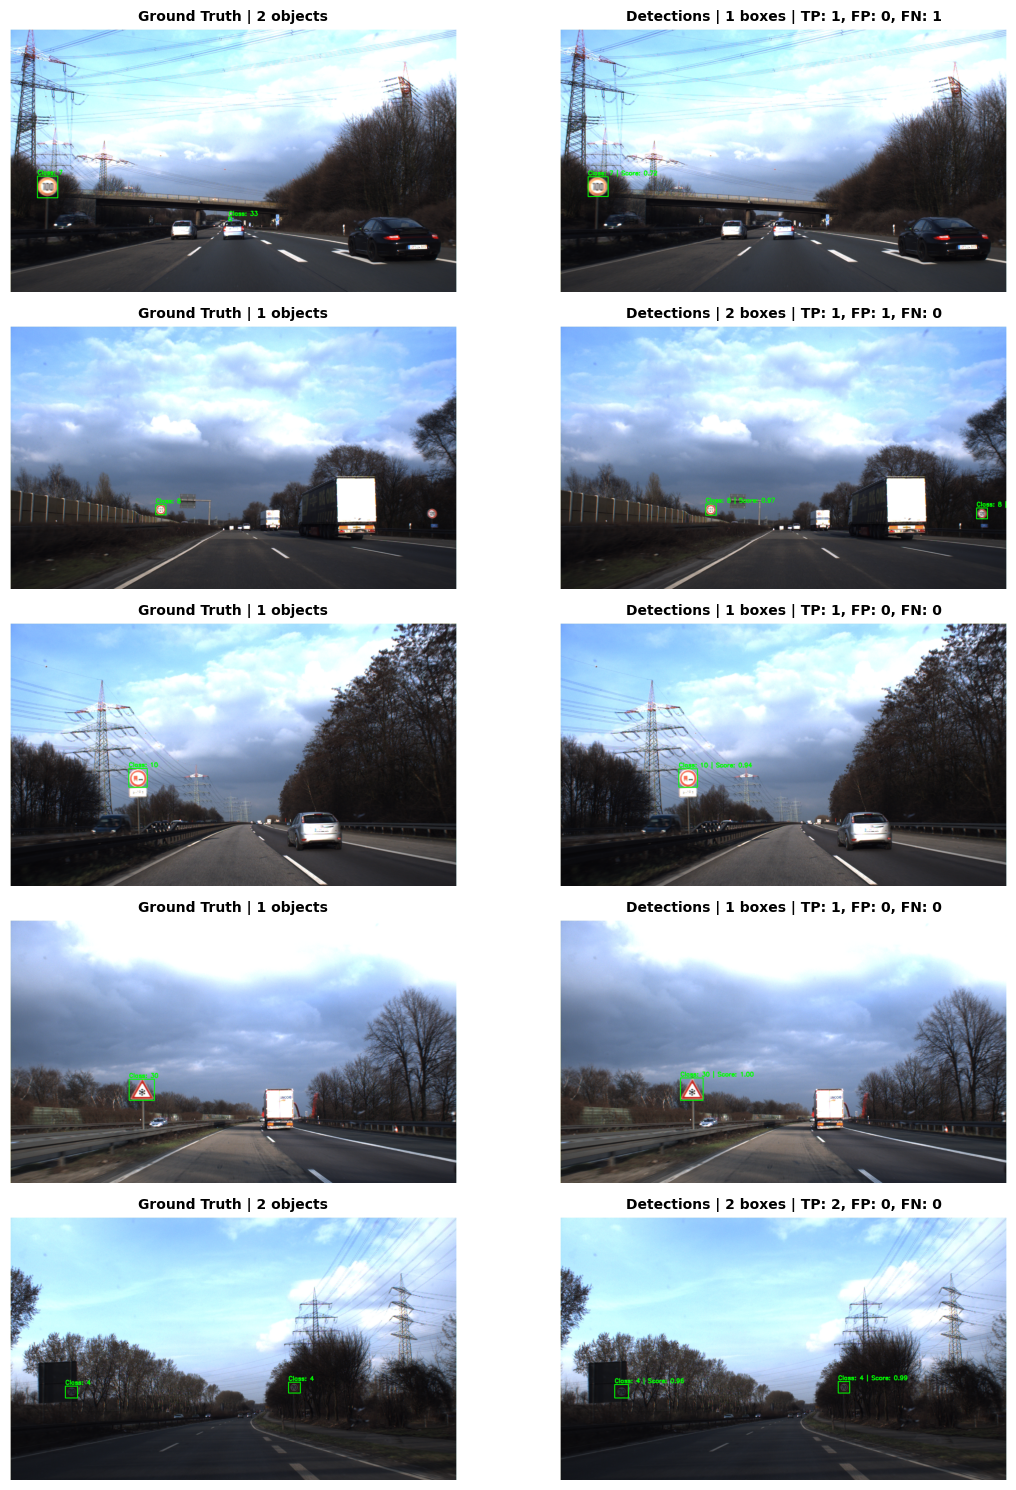

In [25]:
import matplotlib.pyplot as plt
import cv2
import torch
import numpy as np
import os


def draw_boxes(img_np, boxes, labels, scores=None, class_map=None, color=(0, 255, 0)):
    img = img_np.copy()

    for i, ((x1, y1, x2, y2), lbl) in enumerate(zip(boxes, labels)):
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)


        if class_map is not None:
            cls_text = class_map.get(int(lbl), str(int(lbl)))
        else:
            cls_text = str(int(lbl))


        if scores is not None:
            score = float(scores[i])
            text = f"Class: {cls_text} | Score: {score:.2f}"
        else:
            text = f"Class: {cls_text}"


        text_x = int(x1)
        text_y = int(max(0, y1 - 5))

        cv2.putText(
            img,
            text,
            (text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            color,
            2
        )
    return img


def box_iou_single_to_many(box, boxes):

    if len(boxes) == 0:
        return np.zeros(0)

    x1 = np.maximum(box[0], boxes[:, 0])
    y1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[2], boxes[:, 2])
    y2 = np.minimum(box[3], boxes[:, 3])

    inter_w = np.maximum(0, x2 - x1)
    inter_h = np.maximum(0, y2 - y1)
    inter = inter_w * inter_h

    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    union = box_area + boxes_area - inter
    iou = inter / np.maximum(union, 1e-6)
    return iou


def compute_tp_fp_fn(gt_boxes, gt_labels, pred_boxes, pred_labels, iou_thresh=0.5):

    if len(gt_boxes) == 0:
        return 0, len(pred_boxes), 0
    if len(pred_boxes) == 0:
        return 0, 0, len(gt_boxes)

    gt_used = np.zeros(len(gt_boxes), dtype=bool)
    tp = 0
    fp = 0

    for pb, pl in zip(pred_boxes, pred_labels):
        ious = box_iou_single_to_many(pb, gt_boxes)
        if len(ious) == 0:
            fp += 1
            continue

        best_idx = int(np.argmax(ious))
        best_iou = ious[best_idx]

        if best_iou >= iou_thresh and (not gt_used[best_idx]) and (gt_labels[best_idx] == pl):
            tp += 1
            gt_used[best_idx] = True
        else:
            fp += 1

    fn = int(np.sum(~gt_used))
    return tp, fp, fn


max_images = 5

gt_imgs = []
pred_imgs = []
gt_counts = []
pred_counts = []
tp_list = []
fp_list = []
fn_list = []

for count, (img_name, ann) in enumerate(test_annotations.items()):
    if count >= max_images:
        break


    img_path = os.path.join(test_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_np = img.copy()


    gt_boxes = np.array(ann["boxes"])
    gt_labels = np.array(ann["labels"])
    gt_img = draw_boxes(img_np, gt_boxes, gt_labels, color=(0, 255, 0))

    img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)[0]


    score_thresh = 0.5
    mask = output["scores"] > score_thresh

    pred_boxes = output["boxes"][mask].cpu().numpy()
    pred_labels = output["labels"][mask].cpu().numpy() - 1
    pred_scores = output["scores"][mask].cpu().numpy()

    pred_img = draw_boxes(
        img_np,
        pred_boxes,
        pred_labels,
        scores=pred_scores,
        color=(0, 255, 0)
    )


    tp, fp, fn = compute_tp_fp_fn(gt_boxes, gt_labels, pred_boxes, pred_labels)


    gt_imgs.append(gt_img)
    pred_imgs.append(pred_img)
    gt_counts.append(len(gt_boxes))
    pred_counts.append(len(pred_boxes))
    tp_list.append(tp)
    fp_list.append(fp)
    fn_list.append(fn)


n = len(gt_imgs)
if n > 0:
    fig, axes = plt.subplots(n, 2, figsize=(12, 3 * n))


    if n == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(n):
        ax_gt = axes[i, 0]
        ax_gt.imshow(gt_imgs[i])
        ax_gt.set_title(f"Ground Truth | {gt_counts[i]} objects", fontsize=10, fontweight="bold")
        ax_gt.axis("off")


        ax_pred = axes[i, 1]
        ax_pred.imshow(pred_imgs[i])
        ax_pred.set_title(
            f"Detections | {pred_counts[i]} boxes | TP: {tp_list[i]}, FP: {fp_list[i]}, FN: {fn_list[i]}",
            fontsize=10,
            fontweight="bold"
        )
        ax_pred.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
import os
import cv2
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = get_custom_neck_model(num_classes=44)
model.to(device)

best_model_path = "./training_runs/local/best_model.pth"
print("Loading trained weights:", best_model_path)

state_dict = torch.load(best_model_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("Model loaded successfully!")


TEST_DIR = "./gtsdb_data/TestIJCNN2013/TestIJCNN2013Download"

test_files = sorted([f for f in os.listdir(TEST_DIR) if f.lower().endswith(".ppm")])
print(f"Found {len(test_files)} test images")


save_dir = "./test_predictions_unlabeled"
os.makedirs(save_dir, exist_ok=True)
print("Saving predictions to:", save_dir)


for idx, file_name in enumerate(test_files):

    img_path = os.path.join(TEST_DIR, file_name)
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)


    img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
    img_tensor = img_tensor.to(device)

    with torch.no_grad():
        pred = model([img_tensor])[0]

    mask = pred["scores"] > 0.5
    pred_boxes  = pred["boxes"][mask].cpu().numpy()
    pred_scores = pred["scores"][mask].cpu().numpy()
    pred_labels = pred["labels"][mask].cpu().numpy()


    img_pred = img.copy()

    for (x1, y1, x2, y2), lbl, score in zip(pred_boxes, pred_labels, pred_scores):
        cv2.rectangle(img_pred, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 2)
        text = f"{int(lbl)} ({score:.2f})"
        cv2.putText(
            img_pred,
            text,
            (int(x1), int(max(0, y1 - 5))),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0,255,0),
            2
        )


    save_path = os.path.join(save_dir, f"{idx:03d}_{file_name}.png")
    plt.imsave(save_path, img_pred)

print("\Test Predictions complete!")
print(f"Saved to: {save_dir}")


Using device: cuda
Loading trained weights: ./training_runs/local/best_model.pth
Model loaded successfully!
Found 300 test images
Saving predictions to: ./test_predictions_unlabeled
\Test Predictions complete!
Saved to: ./test_predictions_unlabeled
